In [1]:
import pyvisa 
import time
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import os
import datetime
%matplotlib widget

def freq2Idx(freq, freqsAll):
    return int(freq/freqsAll[-1] * len(freqsAll))

def idx2freq(idx, freqs):
    return  ((freqs[-1] - freqs[0])/len(freqs) * idx) + freqs[0]

    # Plotting format for thesis
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=16, labelsize=16)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=18)

In [2]:
#pack df of measured data (measured 2/23/23) from CSVs
####
#port 1 is monopole, 2 is bicon!
####

# Directory containing the CSV files
data_dir_new = '/drBigBoy/darkRadio/daqAnalysisAndExperiments/run1p4/injectionTesting/measuredSParameters/'

# List of file indices to ignore
bad_data_idx = []

# Columns to extract from the CSV
columns_to_extract = ['Frequency', 'S11_Magnitude', 'S11_Phase', 'S22_Magnitude', 'S22_Phase', 'S12_Magnitude', 'S12_Phase']

# Initialize an empty DataFrame to hold the data
df_meas = pd.DataFrame()

# List all files in the directory that match the pattern and are not in the bad data index
for filename in os.listdir(data_dir_new):
    if filename.startswith('pos') and filename.endswith('.csv'):
        # Extract index from the filename and check if it's not in the bad data list
        file_idx = int(filename.split('pos')[-1].split('.')[0])  # Extract the number after 'p'
        if file_idx not in bad_data_idx:
            # Construct full file path
            file_path = os.path.join(data_dir_new, filename)
            # Read the CSV file
            temp_df = pd.read_csv(file_path, usecols=columns_to_extract)
            # Add the index column
            temp_df['Index'] = file_idx
            # Append to the main DataFrame
            df_meas = pd.concat([df_meas, temp_df], ignore_index=True)


#VNA has glitch at 62.00MHz. Replace it with average of two adjacent bins
# Filter rows for the frequencies 61928888 and 62071111 across all indexes
adjacent_freqs_df = df_meas[df_meas['Frequency'].isin([61928888, 62071111])]

# Calculate the average for each S parameter for these frequencies by Index
avg_s_params = adjacent_freqs_df.groupby('Index').mean().drop(columns=['Frequency'])

# Replace the S parameters for frequency 62000000 Hz with the calculated averages
for idx, row in avg_s_params.iterrows():
    df_meas.loc[(df_meas['Frequency'] == 62000000) & (df_meas['Index'] == idx), ['S11_Magnitude', 'S11_Phase', 'S12_Magnitude', 'S12_Phase', 'S22_Magnitude', 'S22_Phase']] = row.values


df_meas['S11_Magnitude_Linear'] = 10 ** (df_meas['S11_Magnitude'] / 20.0)
df_meas['S22_Magnitude_Linear'] = 10 ** (df_meas['S22_Magnitude'] / 20.0)
df_meas['S12_Magnitude_Linear'] = 10 ** (df_meas['S12_Magnitude'] / 20.0)

print("unique sorted position indicies: ",np.sort(df_meas['Index'].unique()))

# Now combined_df contains all the data from the CSV files excluding the bad indices
df_meas.head()  # Show the first few rows of the DataFrame


unique sorted position indicies:  [1 2 3 4 5 6 7 8 9]


,Frequency,S11_Magnitude,S11_Phase,S12_Magnitude,S12_Phase,S22_Magnitude,S22_Phase,Index,S11_Magnitude_Linear,S22_Magnitude_Linear,S12_Magnitude_Linear
0,50000000,-0.062501,-61.335833,-57.559667,163.411452,-2.361924,175.235240,7,0.992830,0.761910,0.001324
1,50057777,-0.063112,-61.390551,-57.335633,161.423027,-2.371851,173.925296,7,0.992760,0.761040,0.001359
2,50115555,-0.060840,-61.462870,-57.165476,160.712944,-2.380790,172.612611,7,0.993020,0.760257,0.001386
3,50173333,-0.060473,-61.531309,-56.777207,158.425941,-2.391200,171.300388,7,0.993062,0.759346,0.001449
4,50231111,-0.058203,-61.589272,-56.529468,156.240475,-2.399834,169.979336,7,0.993321,0.758592,0.001491


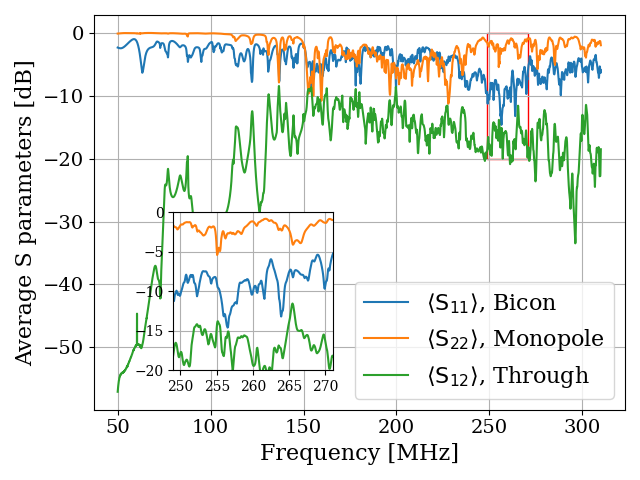

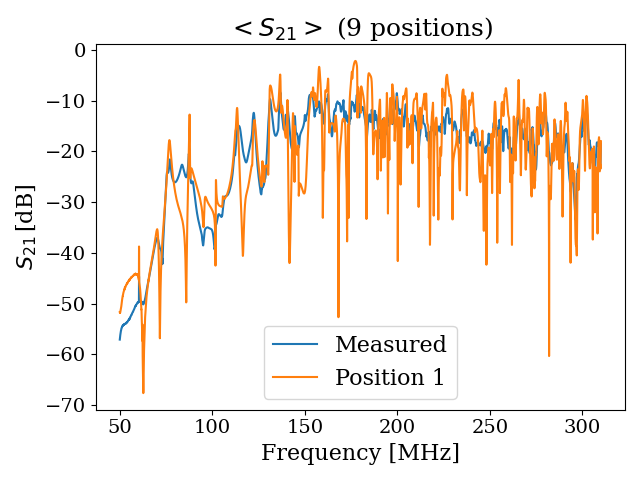

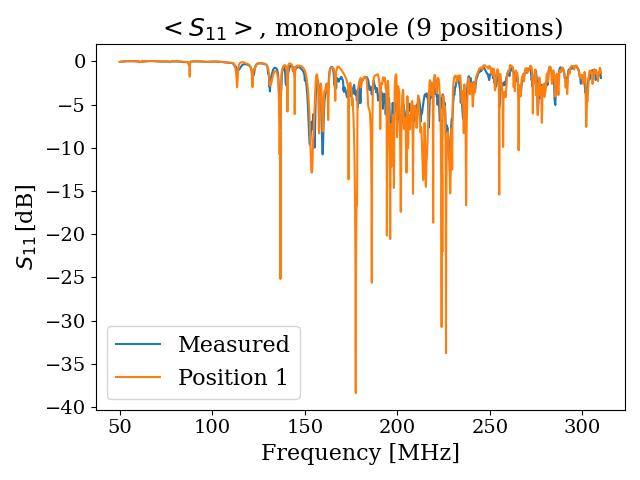

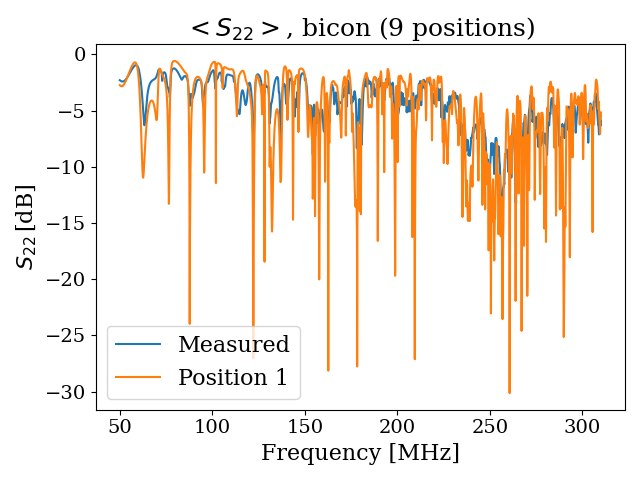

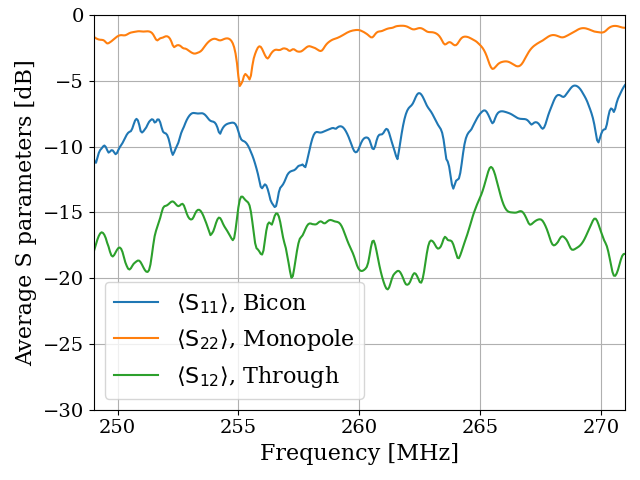

In [3]:
measured_s11_mean_all   = df_meas.groupby('Frequency')['S11_Magnitude_Linear'].mean()
measured_s22_mean_all   = df_meas.groupby('Frequency')['S22_Magnitude_Linear'].mean()
measured_s12_mean_all   = df_meas.groupby('Frequency')['S12_Magnitude_Linear'].mean()

measured_s11_pos1   = df_meas[df_meas['Index'] == 1].groupby('Frequency')['S11_Magnitude_Linear'].mean()
measured_s22_pos1   = df_meas[df_meas['Index'] == 1].groupby('Frequency')['S22_Magnitude_Linear'].mean()
measured_s12_pos1   = df_meas[df_meas['Index'] == 1].groupby('Frequency')['S12_Magnitude_Linear'].mean()

measured_freqs      = df_meas['Frequency'].unique()/1e6


plt.figure()
plt.title(r"$<S_{21}>$ (9 positions)", fontsize = 18)
plt.plot(measured_freqs, 20*np.log10(measured_s12_mean_all), label = 'Measured')
plt.plot(measured_freqs, 20*np.log10(measured_s12_pos1), label = 'Position 1')
plt.xlabel('Frequency [MHz]', fontsize = 16)
plt.ylabel(r'$S_{21}\,$[dB]', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.legend(fontsize = 16)

plt.figure()
plt.title(r"$<S_{11}>$, monopole (9 positions)", fontsize = 18)
plt.plot(measured_freqs, 20*np.log10(measured_s11_mean_all), label = 'Measured')
plt.plot(measured_freqs, 20*np.log10(measured_s11_pos1), label = 'Position 1')
plt.xlabel('Frequency [MHz]', fontsize = 16)
plt.ylabel(r'$S_{11}\,$[dB]', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.legend(fontsize = 16)

plt.figure()
plt.title(r"$<S_{22}>$, bicon (9 positions)", fontsize = 18)
plt.plot(measured_freqs, 20*np.log10(measured_s22_mean_all), label = 'Measured')
plt.plot(measured_freqs, 20*np.log10(measured_s22_pos1), label = 'Position 1')
plt.xlabel('Frequency [MHz]', fontsize = 16)
plt.ylabel(r'$S_{22}\,$[dB]', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.legend(fontsize = 16)

plt.figure()
#plt.title(r"$<S_{xx}>$ (9 positions)", fontsize = 18)
plt.plot(measured_freqs, 20*np.log10(measured_s22_mean_all), label = r'$\langle \mathrm{S}_{11} \rangle$, Bicon')
plt.plot(measured_freqs, 20*np.log10(measured_s11_mean_all), label = r'$\langle \mathrm{S}_{22} \rangle$, Monopole')
plt.plot(measured_freqs, 20*np.log10(measured_s12_mean_all), label = r'$\langle \mathrm{S}_{12} \rangle$, Through')
plt.xlabel('Frequency [MHz]', fontsize = 16)
plt.ylabel('Average S parameters [dB]', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize = 16)
if 1: #add zoom around 260
    plt.xlim(249, 271)
    plt.ylim(-30, 0)
    current_ticks = plt.xticks()[0][1::2]
    plt.xticks(list(current_ticks), fontsize = 14)  

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assuming measured_freqs, measured_s22_mean_all, measured_s11_mean_all, and measured_s12_mean_all are already defined

plt.figure()
# plt.title(r"$<S_{xx}>$ (9 positions)", fontsize = 18)
plt.plot(measured_freqs, 20*np.log10(measured_s22_mean_all), label = r'$\langle \mathrm{S}_{11} \rangle$, Bicon')
plt.plot(measured_freqs, 20*np.log10(measured_s11_mean_all), label = r'$\langle \mathrm{S}_{22} \rangle$, Monopole')
plt.plot(measured_freqs, 20*np.log10(measured_s12_mean_all), label = r'$\langle \mathrm{S}_{12} \rangle$, Through')
plt.xlabel('Frequency [MHz]', fontsize = 16)
plt.ylabel('Average S parameters [dB]', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize = 16)

# Define the zoom region
zoom_x_start = 249
zoom_x_end = 271
zoom_y_start = -20
zoom_y_end = 0

# Add a rectangle to highlight the zoom region
rect = plt.Rectangle((zoom_x_start, zoom_y_start), zoom_x_end - zoom_x_start, zoom_y_end - zoom_y_start,
                     linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

# Create inset of the zoom region
inset_position = [-.2, -.2]  # [left, bottom] in relative coordinates
ax_inset = inset_axes(plt.gca(), width='30%', height='40%', 
                      bbox_to_anchor=(inset_position[0], inset_position[1], 1, 1),
                      bbox_transform=plt.gca().transAxes, loc='center')
ax_inset.plot(measured_freqs, 20*np.log10(measured_s22_mean_all), label = r'$\langle \mathrm{S}_{11} \rangle$, Bicon')
ax_inset.plot(measured_freqs, 20*np.log10(measured_s11_mean_all), label = r'$\langle \mathrm{S}_{22} \rangle$, Monopole')
ax_inset.plot(measured_freqs, 20*np.log10(measured_s12_mean_all), label = r'$\langle \mathrm{S}_{12} \rangle$, Through')
ax_inset.set_xlim(zoom_x_start, zoom_x_end)
ax_inset.set_ylim(zoom_y_start, zoom_y_end)
ax_inset.grid(True)
ax_inset.tick_params(axis='both', which='major', labelsize=10)

# Reducing the number of ticks for the inset plot for better visibility
current_ticks = ax_inset.get_xticks()
ax_inset.set_xticks(current_ticks[1::2])

plt.show()



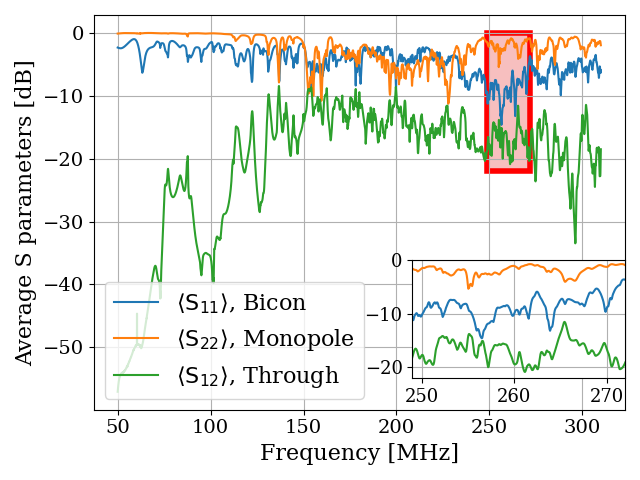

In [4]:
#inset zoom for thesis

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assuming measured_freqs, measured_s22_mean_all, measured_s11_mean_all, and measured_s12_mean_all are already defined

plt.figure()
# plt.title(r"$<S_{xx}>$ (9 positions)", fontsize = 18)
plt.plot(measured_freqs, 20*np.log10(measured_s22_mean_all), label = r'$\langle \mathrm{S}_{11} \rangle$, Bicon')
plt.plot(measured_freqs, 20*np.log10(measured_s11_mean_all), label = r'$\langle \mathrm{S}_{22} \rangle$, Monopole')
plt.plot(measured_freqs, 20*np.log10(measured_s12_mean_all), label = r'$\langle \mathrm{S}_{12} \rangle$, Through')
plt.xlabel('Frequency [MHz]', fontsize = 16)
plt.ylabel('Average S parameters [dB]', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize = 16, loc = 'lower left')

# Define the zoom region
zoom_x_start = 249
zoom_x_end = 272
zoom_y_start = -22
zoom_y_end = 0

# Add a rectangle to highlight the zoom region
shadeZoom = plt.Rectangle((zoom_x_start, zoom_y_start), zoom_x_end - zoom_x_start, zoom_y_end - zoom_y_start,
                     linewidth=1, edgecolor='none', facecolor='lightcoral', alpha = 0.5)
boxZoom = plt.Rectangle((zoom_x_start, zoom_y_start), zoom_x_end - zoom_x_start, zoom_y_end - zoom_y_start,
                     linewidth=4, edgecolor='r', facecolor='none')
plt.gca().add_patch(shadeZoom)
plt.gca().add_patch(boxZoom)

# Create inset of the zoom region
inset_position = [.3, -.27]  # [left, bottom] in relative coordinates
ax_inset = inset_axes(plt.gca(), width='40%', height='30%', 
                      bbox_to_anchor=(inset_position[0], inset_position[1], 1, 1),
                      bbox_transform=plt.gca().transAxes, loc='center')
ax_inset.plot(measured_freqs, 20*np.log10(measured_s22_mean_all), label = r'$\langle \mathrm{S}_{11} \rangle$, Bicon')
ax_inset.plot(measured_freqs, 20*np.log10(measured_s11_mean_all), label = r'$\langle \mathrm{S}_{22} \rangle$, Monopole')
ax_inset.plot(measured_freqs, 20*np.log10(measured_s12_mean_all), label = r'$\langle \mathrm{S}_{12} \rangle$, Through')
ax_inset.set_xlim(zoom_x_start, zoom_x_end)
ax_inset.set_ylim(zoom_y_start, zoom_y_end)
ax_inset.tick_params(axis='both',labelsize=13)

ax_inset.grid(True)

# Reducing the number of ticks for the inset plot for better visibility
current_ticks = ax_inset.get_xticks()
ax_inset.set_xticks(current_ticks[1::2])

plt.show()


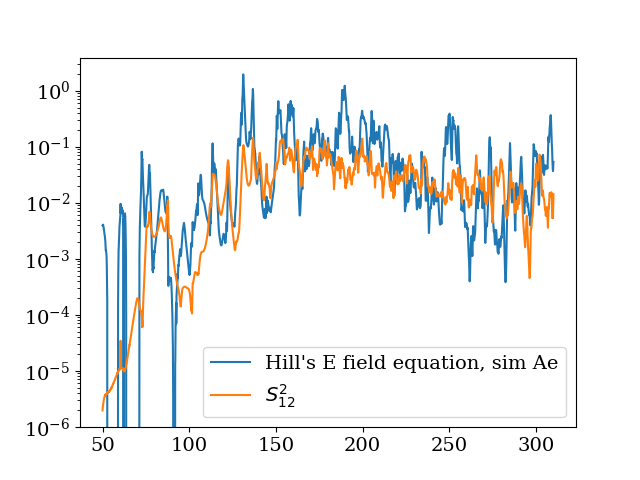

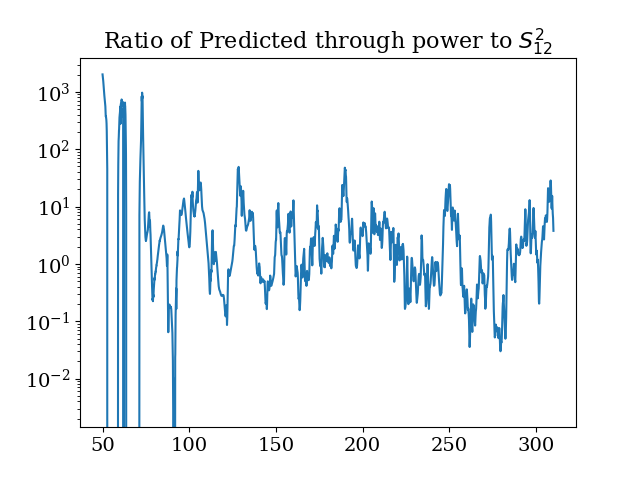

In [5]:

#Q_Ae is corrected
# and is calculated in comsol/simvalidation/2portMonopoleDriveAnalysis.ipynb 
#It is a [freqs:4] array where each row is freq, Q_Ae, upper bound on error, lower bound on error
Q_Ae                    = np.load('../run1p4_analysis/computeLimit/data/QAe_avg_mSquared_FreqMHz_errorFromS12_3_18_24.npy')
Q_Ae_interp             = np.interp(measured_freqs, Q_Ae[0], Q_Ae[1]) 

constant = 1.102e7 #1/(epsilon0 * 377Ohms * volume (8,10,12ft)) [1/(m^2 s)]  

plt.close('all') 
plt.figure()
plt.semilogy()
plt.plot(measured_freqs, (1-measured_s11_mean_all**2)*constant/(measured_freqs*1e6)*Q_Ae_interp, label = "Hill's E field equation, sim Ae")
#plt.plot(measured_freqs, (1-measured_s11_mean_all**2)*(1-measured_s22_mean_all**2)*constant/(measured_freqs*1e6)*1/2*0.9*10*((3e8/measured_freqs/1e6)**2)/4/np.pi, label = "Hill's E field equation, analytic Ae, Q=10")
#plt.plot(measured_freqs, (1-measured_s11_mean_all**2)*(1-measured_s22_mean_all**2)*constant/(measured_freqs*1e6)*1/2*0.9*100*((3e8/measured_freqs/1e6)**2)/4/np.pi, label = "Hill's E field equation, analytic Ae, Q=100")
plt.plot(measured_freqs, (measured_s12_mean_all**2), label = r'$S_{12}^2$')
plt.legend()

plt.figure()
plt.title(r'Ratio of Predicted through power to $S_{12}^2$')
plt.semilogy()
plt.plot(measured_freqs, ((1-measured_s11_mean_all**2)*constant/(measured_freqs*1e6)*Q_Ae_interp)/ (measured_s12_mean_all**2))


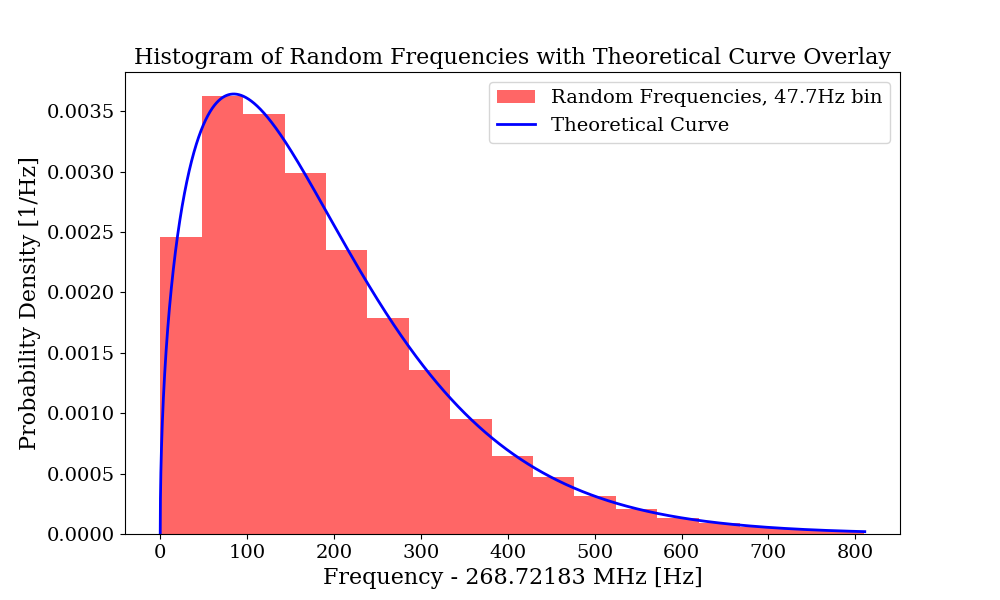

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def theoretical_rayleigh_distribution(nu, nu0, offset = 0,v0=220, vlab=233):
    c = 299792  # km/s
    beta = np.zeros_like(nu)
    mask = nu > nu0
    beta[mask] = (2 * c * vlab) / (v0 ** 2) * np.sqrt((2 * (nu[mask] - (nu0+offset))) / nu0)
    beta = np.minimum(beta, 100)
    a = (2 * c ** 2) / (np.sqrt(np.pi) * v0 * vlab * nu0)
    b = -((beta ** 2 * v0 ** 2) / (4 * vlab ** 2)) - (vlab ** 2 / v0 ** 2)
    lam = a * np.exp(b) * np.sinh(beta)
    return lam

# Generate the theoretical curve
nu0 = 268.72183e6  # Example center frequency in Hz
offset=0
nu0+= offset
nu_min = nu0  # Set the frequency range to start from nu0 to avoid negative values inside sqrt
bin_width = 47.7  # Desired bin width in Hz
num_bins = 17  # Desired number of bins

nu_max = nu_min + bin_width * num_bins
nu = np.linspace(nu_min, nu_max, 10000)
psd_theory = theoretical_rayleigh_distribution(nu, nu0, offset=offset)

# Normalize the theoretical distribution for sampling
psd_theory_normalized = psd_theory / np.sum(psd_theory)

# Draw 10000 values from the theoretical distribution
frequencies = np.random.choice(nu, size=100000, p=psd_theory_normalized)

# Plot the histogram and overlay the theoretical curve
plt.close('all')
plt.figure(figsize=(10, 6))
plt.hist(frequencies-nu0, bins=num_bins, density=True, alpha=0.6, color='r', label='Random Frequencies, 47.7Hz bin')
plt.plot(nu-nu0, psd_theory, 'b-', lw=2, label='Theoretical Curve')
plt.xlabel(f'Frequency - {nu0/1e6} MHz [Hz]')
plt.ylabel('Probability Density [1/Hz]')
plt.title('Histogram of Random Frequencies with Theoretical Curve Overlay')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


810.8999999761581


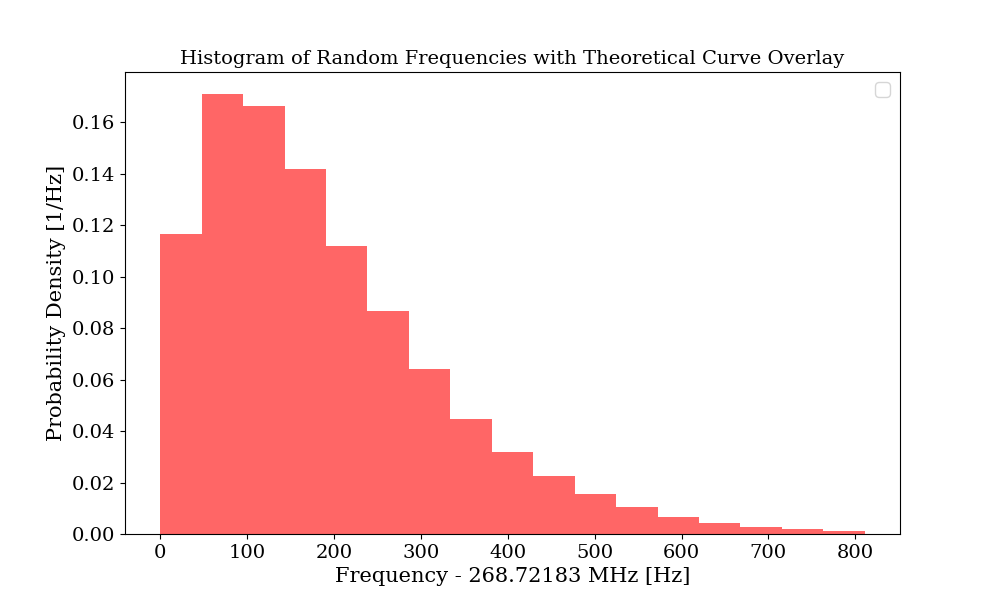

In [251]:
import numpy as np
import matplotlib.pyplot as plt

def theoretical_rayleigh_distribution(nu, nu0, offset=0, v0=220, vlab=233):
    c = 299792  # km/s
    beta = np.zeros_like(nu)
    mask = nu > (nu0 + offset)
    beta[mask] = (2 * c * vlab) / (v0 ** 2) * np.sqrt((2 * (nu[mask] - (nu0 + offset))) / nu0)
    beta = np.minimum(beta, 100)
    a = (2 * c ** 2) / (np.sqrt(np.pi) * v0 * vlab * nu0)
    b = -((beta ** 2 * v0 ** 2) / (4 * vlab ** 2)) - (vlab ** 2 / v0 ** 2)
    lam = a * np.exp(b) * np.sinh(beta)
    
    # Set values to zero for frequencies to the left of nu0 + offset
    lam[nu <= (nu0 + offset)] = 0.0
    
    return lam

# Generate the theoretical curve
nu0 = 268.72183e6  # Example center frequency in Hz
offset = 0  # Example offset adjustment
nu_min = nu0  # Set the frequency range to start from nu0 to avoid negative values inside sqrt
bin_width = 47.7  # Desired bin width in Hz
num_bins = 17  # Desired number of bins

nu_max = nu_min + bin_width * num_bins
print(nu_max-nu_min)
nu = np.linspace(nu_min, nu_max, 1000)
psd_theory = theoretical_rayleigh_distribution(nu, nu0, offset=offset)

# Normalize the theoretical distribution for sampling
psd_theory_normalized = psd_theory / np.sum(psd_theory)

# Draw 10000 values from the theoretical distribution
frequencies = np.random.choice(nu, size=140000, p=psd_theory_normalized)

# Plot the histogram and overlay the theoretical curve
plt.close('all')
plt.figure(figsize=(10, 6))
hist, bin_edges = np.histogram(frequencies, bins=num_bins, density=True, range=(nu_min, nu_max))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
plt.bar(bin_centers-nu0 ,bin_width*hist, align='center', alpha=0.6, color='r', width=bin_width)
#plt.hist(frequencies - nu0, bins=num_bins, density=True, alpha=0.6, color='r', label=f'Random Frequencies, {bin_width} Hz bin')
#plt.plot(nu - nu0,bin_width* psd_theory, 'b-', lw=2, label='Theoretical Curve')
plt.xlabel(f'Frequency - {nu0 / 1e6} MHz [Hz]')
plt.ylabel('Probability Density [1/Hz]')
plt.title('Histogram of Random Frequencies with Theoretical Curve Overlay')
plt.legend()
plt.show()
plt.grid()


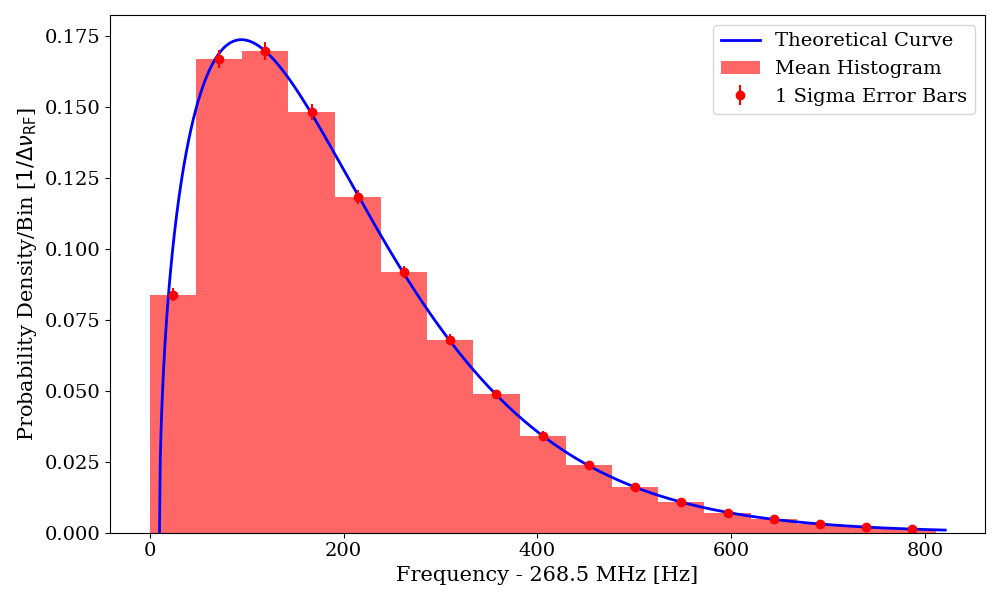

In [264]:
import numpy as np
import matplotlib.pyplot as plt

def theoretical_rayleigh_distribution(nu, nu0, offset=0, v0=220, vlab=233):
    c = 299792  # km/s
    beta = np.zeros_like(nu)
    mask = nu > (nu0 + offset)
    beta[mask] = (2 * c * vlab) / (v0 ** 2) * np.sqrt((2 * (nu[mask] - (nu0 + offset))) / nu0)
    beta = np.minimum(beta, 100)
    a = (2 * c ** 2) / (np.sqrt(np.pi) * v0 * vlab * nu0)
    b = -((beta ** 2 * v0 ** 2) / (4 * vlab ** 2)) - (vlab ** 2 / v0 ** 2)
    lam = a * np.exp(b) * np.sinh(beta)
    
    # Set values to zero for frequencies to the left of nu0 + offset
    lam[nu <= (nu0 + offset)] = 0.0
    
    return lam

def generate_frequency_array(nu0, offset, bin_width, num_bins):
    nu_min = nu0
    nu_max = nu_min + bin_width * num_bins
    nu = np.linspace(nu_min, nu_max, 1000)
    return nu

def monte_carlo_simulation(nu, nu0, num_samples, num_bins, bin_width, offset=0, numFreqs=1000):
    psd_theory = theoretical_rayleigh_distribution(nu, nu0, offset=offset)
    psd_theory_normalized = psd_theory / np.sum(psd_theory)
    
    hist_data = []
    for _ in range(num_samples):
        frequencies = np.random.choice(nu, size=numFreqs, p=psd_theory_normalized)
        hist, bin_edges = np.histogram(frequencies, bins=num_bins, density=True, range=(min(nu), max(nu)))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
        hist_data.append(hist)
    
    mean_hist = np.mean(hist_data, axis=0)
    std_error = np.std(hist_data, axis=0)
    
    return bin_centers, mean_hist, std_error

# Parameters for the simulation
nu0 = 268.5e6  # Example center frequency in Hz
offset = 10  # Example offset adjustment
bin_width = 47.7  # Desired bin width in Hz
num_bins = 17  # Desired number of bins
num_samples = 100 # Number of Monte Carlo samples 
numFreqs = 14000   #number of freqs in freqs array

# Generate the frequency array
nu = generate_frequency_array(nu0, offset, bin_width, num_bins)

# Perform Monte Carlo simulation
bin_centers, mean_hist, std_error = monte_carlo_simulation(nu, nu0, num_samples, num_bins, bin_width, offset=offset, numFreqs=numFreqs)

psd_theory = theoretical_rayleigh_distribution(nu, nu0)
# Plotting the mean histogram with 1 sigma error bars
plt.close('all')
plt.figure(figsize=(10, 6))
plt.plot(nu+offset-nu0, psd_theory*bin_width, 'b-', lw=2, label='Theoretical Curve')
plt.bar(bin_centers-nu0, mean_hist*bin_width, width=bin_width, align='center', alpha=0.6, color='r', label='Mean Histogram')
plt.errorbar(bin_centers-nu0, mean_hist*bin_width, yerr=std_error*bin_width, fmt='o', color='r', label='1 Sigma Error Bars')
plt.xlabel(f'Frequency - {nu0/1e6} MHz [Hz]')
plt.ylabel(r'Probability Density/Bin [$1/\Delta \nu_\mathrm{RF}$]')
plt.legend()
plt.tight_layout()
plt.show()




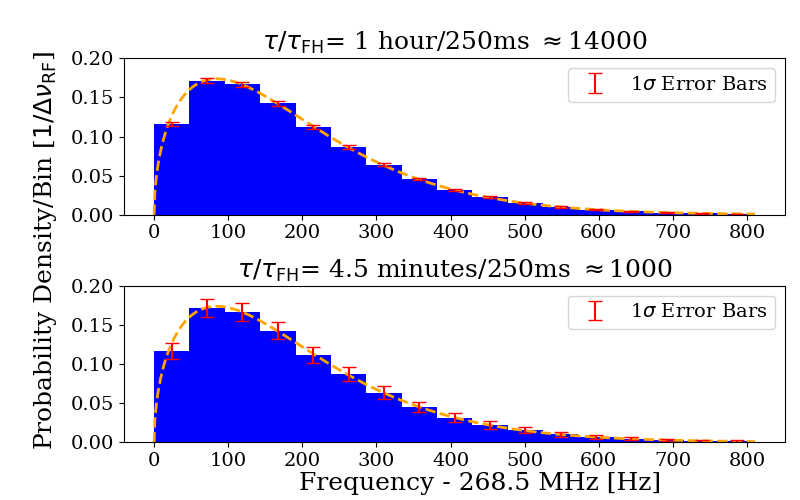

In [334]:
import numpy as np
import matplotlib.pyplot as plt

def theoretical_rayleigh_distribution(nu, nu0, offset=0, v0=220, vlab=233):
    c = 299792  # km/s
    beta = np.zeros_like(nu)
    mask = nu > (nu0 + offset)
    beta[mask] = (2 * c * vlab) / (v0 ** 2) * np.sqrt((2 * (nu[mask] - (nu0 + offset))) / nu0)
    beta = np.minimum(beta, 100)
    a = (2 * c ** 2) / (np.sqrt(np.pi) * v0 * vlab * nu0)
    b = -((beta ** 2 * v0 ** 2) / (4 * vlab ** 2)) - (vlab ** 2 / v0 ** 2)
    lam = a * np.exp(b) * np.sinh(beta)
    
    # Set values to zero for frequencies to the left of nu0 + offset
    lam[nu <= (nu0 + offset)] = 0.0
    
    return lam

def generate_frequency_array(nu0, offset, bin_width, num_bins):
    nu_min = nu0
    nu_max = nu_min + bin_width * num_bins
    nu = np.linspace(nu_min, nu_max, 1000)
    return nu

def monte_carlo_simulation(nu, nu0, num_samples, num_bins, bin_width, offset=0, numFreqs=1000):
    psd_theory = theoretical_rayleigh_distribution(nu, nu0, offset=offset)
    psd_theory_normalized = psd_theory / np.sum(psd_theory)
    
    hist_data = []
    for _ in range(num_samples):
        frequencies = np.random.choice(nu, size=numFreqs, p=psd_theory_normalized)
        hist, bin_edges = np.histogram(frequencies, bins=num_bins, density=True, range=(min(nu), max(nu)))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
        hist_data.append(hist)
    
    mean_hist = np.mean(hist_data, axis=0)
    std_error = np.std(hist_data, axis=0)
    
    return bin_centers, mean_hist, std_error

# Parameters for the simulation
nu0_list = [268.5e6, 268.5e6]
offset_list = [0, 0]
bin_width = 47.7  # Desired bin width in Hz
num_bins = 17  # Desired number of bins
num_samples = 1000  # Number of Monte Carlo samples
numFreqs_list = [14000, 1000]
labelList   =['= 1 hour/250ms', '= 4.5 minutes/250ms']

fig, axes = plt.subplots(2, 1, figsize=(8,5))

for i, (nu0, offset, numFreqs) in enumerate(zip(nu0_list[:2], offset_list[:2], numFreqs_list[:2])):
    nu = generate_frequency_array(nu0, offset, bin_width, num_bins)
    bin_centers, mean_hist, std_error = monte_carlo_simulation(nu, nu0, num_samples, num_bins, bin_width, offset=offset, numFreqs=numFreqs)
    psd_theory = theoretical_rayleigh_distribution(nu, nu0, offset=offset)

    ax = axes[i]
    ax.plot(nu + offset - nu0, psd_theory * bin_width, 'orange', linestyle = '--', lw=2)
    ax.bar(bin_centers - nu0, mean_hist * bin_width, width=bin_width, align='center', alpha=1, color='blue')
    #ax.errorbar(bin_centers - nu0, mean_hist * bin_width, yerr=std_error * bin_width, fmt='o', color='r', label='1 Sigma Error Bars', markersize = 4)
    ax.errorbar(bin_centers - nu0, mean_hist * bin_width, yerr=std_error * bin_width, fmt='none', color='r', label=r'1$\sigma$ Error Bars', markersize=4, capsize=5)

    #ax.set_xlabel(f'Frequency - {nu0/1e6} MHz [Hz]')
    #ax.set_ylabel(r'Probability Density/Bin [$1/\Delta \nu_\mathrm{RF}$]')
    ax.legend()
    ax.set_title(rf'$\tau/\tau_\mathrm{{FH}}$' + labelList[i] +rf' $\approx${numFreqs}', fontsize = 18)
    ax.set_yticks([0, 0.05, 0.10, 0.15, 0.20])


# Add the common x-axis and y-axis labels
fig.text(0.6, 0.02, f'Frequency - {nu0_list[0]/1e6} MHz [Hz]', ha='center', fontsize=18)
fig.text(0.04, 0.5, r'Probability Density/Bin [$1/\Delta \nu_\mathrm{RF}$]', va='center', fontsize=18, rotation='vertical')

plt.tight_layout(rect=[0.07, 0.03, 1, 0.97])
plt.show()


In [ ]:
# Initialize VISA resource manager
rm = pyvisa.ResourceManager()

#print(rm.list_resources())


# Connect to the Rigol DSG830
# Replace 'USB0::0x1AB1::0x0960::DG8C123456789::INSTR' with the correct VISA address for your device
try:
    inst.close()
    print('closed')
except: 
    print('good')

inst = rm.open_resource('USB0::6833::2460::DSG8E191700026::0::INSTR')


# Function to set frequency
def set_frequency(freq):
    """
    Set the frequency of the signal generator.

    Parameters:
    freq (float): Frequency in Hz
    """
    inst.write(f'FREQ {freq}')

# Function to set amplitude
def set_amplitude(amp):
    """
    Set the amplitude of the signal generator.

    Parameters:
    amp (float): Amplitude in dBm
    """
    inst.write(f'POW {amp}')

# Generate the theoretical line 
nu0 = 268.e6  # Example center frequency in Hz
nu_min = nu0  # Set the frequency range to start from nu0 to avoid negative values inside sqrt
nu_max = nu0 + 1e3
nu = np.linspace(nu_min, nu_max, 10000)
psd_theory = theoretical_rayleigh_distribution(nu, nu0)

frequencies = np.random.choice(nu, size=1000000, p=psd_theory_normalized)
#frequencies = np.repeat(268729844.392, 1e6)
#frequencies = [268.7217*1e6,268.7227*1e6, 268.7237*1e6,268.7247*1e6,268.7257*1e6,268.7267*1e6,268.7277*1e6,268.7287*1e6,268.7297*1e6,268.7307*1e6]*1000000
#frequencies = [268729844.392+offset for offset in np.linspace(0,47.683*4*10,11)]*10000
for freq in frequencies:
    set_frequency(freq)
    #print(f'frequency set to {freq}')
    print(f'frequency set at {datetime.datetime.now()}')
    time.sleep(0.25)
inst.close()

In [9]:
"""
A collection of functions to perform a dark photon search on an averaged spectrum


Functions
-------
median_filt(
    
):
    LPF for spectrum. Recomended as a pre-filter if
    spec contains large, very narrow candidates

butter_filt(

):
    LPF for spectrum. 

SG_filt(

):
    LPF for spectrum

match_filt(
    
):
    Performs a matched filtering on approx. normally distributed data
    Internal helper functions include freq2idx and genNuSteps

set_limit(

):
    Sets a limit (or series of limits) on an array of 
    normally distributed data (or list of arrays of normal data)

get_required_sigma(

):
    Given a number of samples and a desired confidence limit, tells you how 
    many "N" sigma you need to go to in order to be CL% confident no samples
    are above the calculated "N" 
"""
import numpy as np 
import scipy.signal as spsig
import scipy.ndimage as spim
import cupyx.scipy.ndimage as cpim
import cupy as cp
from scipy.signal import butter, filtfilt
import scipy.stats
import scipy.special
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib widget


def median_filt(spec, filter_size=50, gpuFlag = 1):
    """
    Function to apply median filtering to a spectrum.

    Parameters
    ----------
    spectrum : array
        The input power spectrum.

    filter_size : int, optional
        Size of the median filter. Default is 50.

    Returns
    -------
    spectrum_filtered : array
        The median-filtered spectrum.
    """
    if gpuFlag:
        spectrum_gpu = cp.array(spec)
        spectrum_filtered_gpu = cpim.median_filter(
            spectrum_gpu,
            size=(filter_size),
            origin=0
        )
        spectrum_filtered = spectrum_filtered_gpu.get()
    else:
        spectrum_filtered = spim.median_filter(
            spec,
            size=(filter_size),
            origin=0
        )
    return spectrum_filtered

def butter_filt(spec, cutoff=40000, order=6):
    """
    Function to apply Butterworth low-pass filtering to a spectrum.

    Parameters
    ----------
    spectrum : array
        The input power spectrum.

    cutoff : int, optional
        Cutoff frequency for the filter. Default is 40000.

    order : int, optional
        Order of the filter. Default is 6.

    Returns
    -------
    spectrum_filtered : array
        The Butterworth low-pass filtered spectrum.
    """
    nyq = 0.5 * len(spec)  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    spectrum_filtered = filtfilt(b, a, spec)
    return spectrum_filtered

def sg_filt(spec, window_length=51, polyorder=4):
    """
    Apply a Savitzky-Golay filter to the spectrum.

    Parameters
    ----------
    window_length : int, optional
        Length of the filter window; must be a positive odd integer, default is 51.
    polyorder : int, optional
        Order of the polynomial used to fit the samples, default is 1.

    Returns
    -------
    arr
        Filtered spectrum.
    """
    spectrum_filtered = spsig.savgol_filter(spec, window_length=window_length, polyorder=polyorder)
    return spectrum_filtered

def matched_filt(freqs, 
    spec, 
    startFreq, 
    stopFreq, 
    percent, 
    overlap
    ):
    """
    Apply a matched filter to the input spectrum over a specified frequency range.

    This function divides the freqs range into steps and applies a convolution
    operation with a lambda template for each step. The function returns the 
    convolved output for each freqs segment.

    Parameters
    ----------
    freqs : array-like
        Array of frequencies corresponding to the input spectrum.
    spec : array-like
        Array of spectral values to be filtered.
    startFreq : float
        Starting freqs of the range over which the filter is applied.
    stopFreq : float
        Stopping frequency of the range over which the filter is applied.
    percent : float
        Percentage to determine the step size between successive frequencies in the
        range (startFreq to stopFreq).
    overlap : int
        Number of overlapping elements between successive frequency segments.

    Returns
    -------
    tuple
        A tuple containing two lists:
        - outputFreqs: List of arrays with the frequencies corresponding to each segment.
        - outputConv: List of arrays with the convolved values for each segment.

    Notes
    -----
    Frequency step generation (`gen_nu_steps`) is
    defined internally within this function.
    """
    def gen_nu_steps(freqs, startFreq, stopFreq, percent):
        freq    = startFreq
        nuStepList  = []
        while freq < stopFreq:
            #if freq > freqs:
            #    nu0Arr.append(400)
            nuStepList.append(freq)
            endFreq = freq + freq*percent/100
            freq = endFreq
        nuStepList.append(stopFreq) 
        return nuStepList
        
    nuStepList  = gen_nu_steps(freqs, startFreq, stopFreq, percent)
    outputConv  = []
    outputFreqs = []
    #change template over frequency range
    for i, nu in enumerate(nuStepList[0:-1]):
        idxStart        = freq2idx(nuStepList[i], freqs) - overlap
        nu0             = nuStepList[i] + (nuStepList[i+1] - nuStepList[i])/2
        if 0: #nuStepList[i+1] == stopFreq:
            idxStop     = freq2idx(nuStepList[i+1], freqs) - 10
        else:
            idxStop     = freq2idx(nuStepList[i+1], freqs) + overlap
        lamOut      = lam(freqs, nu0, p0=1, nBins=100)
        subConv     = np.convolve(np.flip(lamOut[1]), spec[idxStart:idxStop], mode='same')[overlap:-overlap]
        subFreqs    = freqs[idxStart+overlap:idxStop-overlap]
        
        outputConv.append(subConv)
        outputFreqs.append(subFreqs)
    return (outputFreqs, outputConv)

def lam(nu, nu0, p0 = None, nBins=None, v0=220, vlab=233, offset = 0):
    """
    Lambda function for matched filtering.
    Work in MHz, this will explode for large frequency values (ie 100e6 Hz)
    velocity args in km/s
    vlab has yearly modulation between about 220 and 255, see fig 3a in Gramolin
    output is normilized to p0 if given

    Parameters
    ----------
    nu : float
        Frequency.
    nu0 : float
        Center frequency.
    p0 : float, optional
        Power normalization value, default is None.
    nBins : int, optional
        Number of bins, default is None.
    v0 : int, optional
        Velocity parameter, default is 220.
    vlab : int, optional
        Lab velocity parameter, default is 233.
    offset : int, optional
        Frequency offset, default is 0.

    Returns
    -------
    tuple
        Frequencies and output power spectral density.
    """
    if nBins is not None:
        # find the index of nu0 in nu array
        idx = np.abs(nu-nu0).argmin()

        # calculate the slice start and end indices
        start_idx = max(0, idx - nBins//2)
        end_idx = min(len(nu), idx + nBins//2)
        nu = nu[start_idx:end_idx]

    c       = 299792 #km/s
    nu0     = nu0 + offset
    beta    = np.zeros_like(nu) # initialise beta with zeros

    mask    = (nu > nu0) # create a mask of values where nu > nu0
    # calculate beta only for values where nu > nu0
    beta[mask] = (2*c*vlab)/(v0**2) * np.sqrt((2*(nu[mask]-nu0))/(nu0))
    beta    = np.minimum(beta, 100)
    a       = (2*c**2)/(np.sqrt(np.pi)*v0*vlab*nu0)
    b       = -((beta**2*v0**2)/(4*vlab**2)) - (vlab**2/v0**2) 

    lamArr  = a*np.exp(b)*np.sinh(beta)
    if p0 is not None:
        outPSD = p0/np.sum(lamArr) * lamArr #normilize to p0
    else:
        outPSD = lamArr

    return nu, outPSD 

def get_required_sigma(nBins, desired_confidence):    
    """
    Calculate the required standard deviation (sigma) level to achieve a specified
    confidence level that none of the samples in a given number of bins will exceed
    that sigma level.

    The function solves for the sigma level using the cumulative distribution function
    of the normal distribution and the binomial probability for the given number of bins.

    Parameters
    ----------
    nBins : int
        The number of bins or samples drawn from a normal distribution.
    desired_confidence : float
        The desired confidence level (between 0 and 1) for the probability that none
        of the samples will exceed the calculated sigma level. eg 0.95

    Returns
    -------
    float
        The calculated sigma level required to achieve the desired confidence.

    Notes
    -----
    The function uses the `fsolve` method from SciPy's optimize module to solve for
    the sigma value. If the solver does not converge, it returns a guessed value
    based on the inverse error function.
    """

    desired_confidence = 1-desired_confidence
    def probability_greater_than(sigma):
        return 0.5-scipy.special.erf(sigma/np.sqrt(2))/2

    def binomial(N, num_successes, prob_of_success):
        return scipy.special.comb(N, num_successes)*prob_of_success**(num_successes)*(1-prob_of_success)**(N-num_successes)

    def probability_none_above(nBins, sigma):
        # returns probability that after nBins of draws from a normal distribution
        # that none of the draws will be above the sigma upper limit (mean+sigma)
        return 1-binomial(nBins, nBins, 1-probability_greater_than(sigma))

    guess     = scipy.special.erfinv(1-(2*(desired_confidence)/nBins))*np.sqrt(2) #from taylor expantion
    nSig, solDict, itr, msg   = fsolve(lambda sigma: probability_none_above(nBins, sigma)-desired_confidence, guess, full_output=True)
    nSig = nSig[0]
    if itr != 1:
        print('fSolve in get_required_sigma failed. Using guess')
        print(msg)
        nSig = guess
    
    return nSig

def set_lim(freqs, spec, CL):
    """
    Calculate the frequency limits and standard deviations for the given spectra.

    This function computes the limits by applying the required sigma to each segment
    of the input spectra and then concatenates the results to form the complete limit.
    It also flattens and concatenates the input frequency and spectrum arrays to match
    the shape of the limit.

    Parameters
    ----------
    freqs : arr or list of arr
        Array(s) of frequencies corresponding to the input spectra. If a single array
        is provided, it is wrapped in a list to form an array of arrays.
    spec : arr or list of arr
        Array(s) of spectra to calculate the limits for. If a single array is provided,
        it is wrapped in a list to form an array of arrays.
    CL : float
        Confidence level for calculating the required sigma. This value is used to
        determine how many standard deviations to apply to the spectra.

    Returns
    -------
    tuple
        A tuple containing three arrays: the concatenated frequency array, the
        concatenated spectrum array, and the calculated limit array.
    """
    # If the inputs are 1-D arrays, wrap them in a list to make them an array of arrays
    if isinstance(spec, (np.ndarray, list)) and not isinstance(spec[0], (np.ndarray, list)):
        freqs   = [freqs]
        spec    = [spec]
    nSamps = len(np.hstack(freqs))
    nSig = get_required_sigma(nSamps, CL)

    limits = []
    for idx in range(len(spec)):
        limits.append(nSig * 1.4826 * scipy.stats.median_abs_deviation(spec[idx]))

    limit   = np.concatenate([np.repeat(limit, len(freqs)) for limit, freqs in zip(limits, freqs)])
    freqs   = np.hstack(freqs)
    spec    = np.hstack(spec)

    return (freqs, spec, limit)

def freq2idx(freq, freqs):
    return int(freq/freqs[-1]*len(freqs))



In [10]:
## load and pack H5 files

import sys 
import numpy as np
sys.path.insert(0, './main_daq/')
import settings as s
import matplotlib.pyplot as plt 
import importlib
importlib.reload(s)
from cupyx.profiler import benchmark
import h5py
import os
import re
import time
import datetime
from datetime import datetime
import pandas as pd
import math
from scipy.optimize import curve_fit

sys.path.insert(0, '../../../drlib')
import drlib as dr
%matplotlib widget

def mad_np(arr):
    median = np.median(arr)
    return np.median(np.abs(arr-median))



dataDir         = '/drBiggerBoy/run1p4_injectionTest2/'
filename        = 'packedh5.hdf5'
databaseFile    = 'database.txt'

antSpecSufix    = 'ALL_FFTs_6_11_24'

databaseDf      = pd.read_csv(dataDir + databaseFile)

totalAcqs       = int(open(dataDir + databaseFile, 'r'
                    ).readlines()[-1].split(',')[0].strip()) + 1 

print(totalAcqs)
    
# Generate antIdx and termIdx from database file
# Open the data file and read the lines
# should rewrite this to use DF
with open(dataDir + databaseFile, 'r') as f:
    # Skip the header line
    next(f)
    # Initialize the two arrays
    antIdx = []
    termIdx = []
    # Loop through the remaining lines and extract the acqNum values
    for line in f:
        # Split the line into fields
        fields = line.strip().split(',')
        # Extract the SWITCH_POS and ACQ NUM values
        switch_pos = int(fields[2])
        acq_num = int(fields[0])
        # Append the acqNum value to the appropriate array
        if switch_pos == 0:
            antIdx.append(acq_num)
        elif switch_pos == 1:
            termIdx.append(acq_num)
    

# Print the results
print("antIdx =", antIdx)

for i in antIdx:
    print(i)


#pack pre proc dataset

try:
    f.close()
    print("closed")
except:
    print("didn't close")
    pass

rawDataDir      = dataDir + 'data/'
fileList        = os.listdir(rawDataDir)
fileList.sort(key=lambda f: int(re.sub('\D', '', f)))
newDataDir      = dataDir
fileName        = 'packedh5.hdf5'
if 0: #will overwrite!!!

    f               = h5py.File(newDataDir + fileName, 'w')

    #init empty dataset
    print(f'initilizing dataset 8388609x{totalAcqs}')
    specA_W    = f.create_dataset('spec_W_chA', (8388609, totalAcqs), chunks = (2**16,2**0), dtype = 'f')
    specB_W    = f.create_dataset('spec_W_chB', (8388609, totalAcqs), chunks = (2**16,2**0), dtype = 'f')
    print(specA_W)
    print(specB_W)

    ##############################################################
    #Main loop
    ##############################################################
    numFiles        = 0
    numMeasData     = 0
    numRigolSpec    = 0

    compType = False
    chunks = None #must add chunks arg to create dataset calls

    for fileidx, file in enumerate(fileList):
        if fileidx % 1 == 0:
            print(file)
        dataset         = h5py.File(rawDataDir +  file, 'r')
        numFiles        += 1
        measDataKeys    = list(dataset.keys())
        measDataKeys.sort(key=lambda f: int(re.sub('\D', '', f)))
        #measDataKeys = [int(key) for key in measDataKeys]

        for measData in measDataKeys:
            print(measData)
            measDataInt = int(measData)
            '''Dumb check. Is the date in raw h5 measData the same as what
            the database thinks it is? Since we previously check that dates
            are consectutive this also checks that dates 
            in raw h5 are consecutive'''
            '''datasetDf   = pd.read_hdf(rawDataDir + file, key = measData)#raw H5 
            dateTimeStr = datasetDf.columns[0][0]#datetime extracted from raw H5
            dateTime    = datetime.strptime(dateTimeStr, '%Y-%m-%d %H:%M:%S.%f')'''

            '''Check database at a measData has the same datetime as we are about
            to load into new h5'''
            '''if not (dateTime==database[database['measData'] == measDataInt].index):
                print('Dates got jumbled at measData', measDataInt)'''
            specA_W_np        = np.float32(dataset[measData]['chASpec_W'])
            specB_W_np        = np.float32(dataset[measData]['chBSpec_W'])


            specA_W[:, measDataInt]    = specA_W_np
            specB_W[:, measDataInt]    = specB_W_np

f.close()






432
antIdx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 21

NameError: name 'data' is not defined

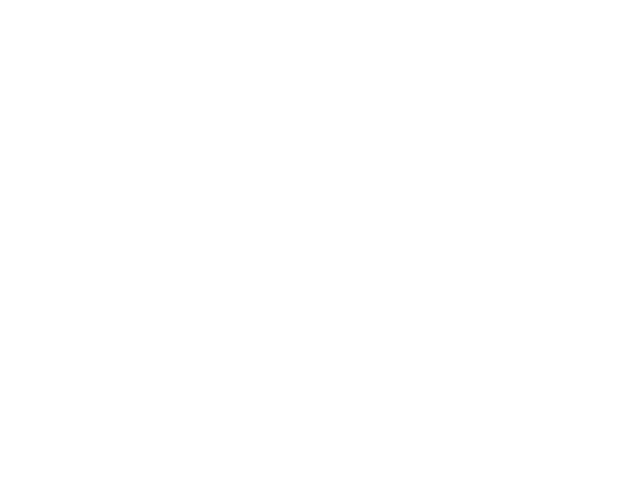

In [11]:
if 0: #load W spec, if didn't create spec above
    data = np.load('./data/oneHour_268p72183MHz_n25p8dBm_126dBAtt_onePos_40cmMonopole_run1p4ampChain.npy', allow_pickle=True).item()['chBSpec_W'][1:]

freqs       = np.linspace(0, 400e6, 2**23, dtype=np.float64)
analysisIdxStart     = freq2Idx(260e6, freqs)
analysisIdxStop     = freq2Idx(280e6, freqs)

#[analysisIdxStart:analysisIdxStop]

plt.close('all')
plt.figure()
plt.plot(freqs[analysisIdxStart:analysisIdxStop]/1e6, 1e12*data[analysisIdxStart:analysisIdxStop])
plt.xlabel('Frequency [MHz]')
plt.ylabel('Output Referred Power/Bin [pW/47.7Hz]')

In [59]:
"""A collection of functions to perform a dark photon search on an averaged spectrum


Functions
-------
median_filt(
    
):
    LPF for spectrum. Recomended as a pre-filter if
    spec contains large, very narrow candidates

butter_filt(

):
    LPF for spectrum. 

SG_filt(

):
    LPF for spectrum

match_filt(
    
):
    Performs a matched filtering on approx. normally distributed data
    Internal helper functions include freq2idx and genNuSteps

set_limit(

):
    Sets a limit (or series of limits) on an array of 
    normally distributed data (or list of arrays of normal data)

get_required_sigma(

):
    Given a number of samples and a desired confidence limit, tells you how 
    many "N" sigma you need to go to in order to be CL% confident no samples
    are above the calculated "N" 
"""
import numpy as np 
import scipy.signal as spsig
import scipy.ndimage as spim
import cupyx.scipy.ndimage as cpim
import cupy as cp
from scipy.signal import butter, filtfilt
import scipy.stats
import scipy.special
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib widget


def median_filt(spec, filter_size=50, gpuFlag = 1):
    """
    Function to apply median filtering to a spectrum.

    Parameters
    ----------
    spectrum : array
        The input power spectrum.

    filter_size : int, optional
        Size of the median filter. Default is 50.

    Returns
    -------
    spectrum_filtered : array
        The median-filtered spectrum.
    """
    if gpuFlag:
        spectrum_gpu = cp.array(spec)
        spectrum_filtered_gpu = cpim.median_filter(
            spectrum_gpu,
            size=(filter_size),
            origin=0
        )
        spectrum_filtered = spectrum_filtered_gpu.get()
    else:
        spectrum_filtered = spim.median_filter(
            spec,
            size=(filter_size),
            origin=0
        )
    return spectrum_filtered

def butter_filt(spec, cutoff=40000, order=6):
    """
    Function to apply Butterworth low-pass filtering to a spectrum.

    Parameters
    ----------
    spectrum : array
        The input power spectrum.

    cutoff : int, optional
        Cutoff frequency for the filter. Default is 40000.

    order : int, optional
        Order of the filter. Default is 6.

    Returns
    -------
    spectrum_filtered : array
        The Butterworth low-pass filtered spectrum.
    """
    nyq = 0.5 * len(spec)  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    spectrum_filtered = filtfilt(b, a, spec)
    return spectrum_filtered

def sg_filt(spec, window_length=51, polyorder=4):
    """
    Apply a Savitzky-Golay filter to the spectrum.

    Parameters
    ----------
    window_length : int, optional
        Length of the filter window; must be a positive odd integer, default is 51.
    polyorder : int, optional
        Order of the polynomial used to fit the samples, default is 1.

    Returns
    -------
    arr
        Filtered spectrum.
    """
    spectrum_filtered = spsig.savgol_filter(spec, window_length=window_length, polyorder=polyorder)
    return spectrum_filtered

def matched_filt(freqs, 
    spec, 
    startFreq, 
    stopFreq, 
    percent, 
    overlap
    ):
    """
    Apply a matched filter to the input spectrum over a specified frequency range.

    This function divides the freqs range into steps and applies a convolution
    operation with a lambda template for each step. The function returns the 
    convolved output for each freqs segment.

    Parameters
    ----------
    freqs : array-like
        Array of frequencies corresponding to the input spectrum.
    spec : array-like
        Array of spectral values to be filtered.
    startFreq : float
        Starting freqs of the range over which the filter is applied.
    stopFreq : float
        Stopping frequency of the range over which the filter is applied.
    percent : float
        Percentage to determine the step size between successive frequencies in the
        range (startFreq to stopFreq).
    overlap : int
        Number of overlapping elements between successive frequency segments.

    Returns
    -------
    tuple
        A tuple containing two lists:
        - outputFreqs: List of arrays with the frequencies corresponding to each segment.
        - outputConv: List of arrays with the convolved values for each segment.

    Notes
    -----
    Frequency step generation (`gen_nu_steps`) is
    defined internally within this function.
    """
    def gen_nu_steps(freqs, startFreq, stopFreq, percent):
        freq    = startFreq
        nuStepList  = []
        while freq < stopFreq:
            #if freq > freqs:
            #    nu0Arr.append(400)
            nuStepList.append(freq)
            endFreq = freq + freq*percent/100
            freq = endFreq
        nuStepList.append(stopFreq) 
        return nuStepList
        
    nuStepList  = gen_nu_steps(freqs, startFreq, stopFreq, percent)
    outputConv  = []
    outputFreqs = []
    #change template over frequency range
    for i, nu in enumerate(nuStepList[0:-1]):
        idxStart        = freq2idx(nuStepList[i], freqs) - overlap
        nu0             = nuStepList[i] + (nuStepList[i+1] - nuStepList[i])/2
        if 0: #nuStepList[i+1] == stopFreq:
            idxStop     = freq2idx(nuStepList[i+1], freqs) - 10
        else:
            idxStop     = freq2idx(nuStepList[i+1], freqs) + overlap
        lamOut      = lam(freqs, nu0, p0=1, nBins=100)
        subConv     = np.convolve(np.flip(lamOut[1]), spec[idxStart:idxStop], mode='same')[overlap:-overlap]
        subFreqs    = freqs[idxStart+overlap:idxStop-overlap]
        
        outputConv.append(subConv)
        outputFreqs.append(subFreqs)
    return (outputFreqs, outputConv)

def lam(nu, nu0, p0 = None, nBins=None, v0=220, vlab=233, offset = 0):
    """
    Lambda function for matched filtering.
    Work in MHz, this will explode for large frequency values (ie 100e6 Hz)
    velocity args in km/s
    vlab has yearly modulation between about 220 and 255, see fig 3a in Gramolin
    output is normilized to p0 if given

    Parameters
    ----------
    nu : float
        Frequency.
    nu0 : float
        Center frequency.
    p0 : float, optional
        Power normalization value, default is None.
    nBins : int, optional
        Number of bins, default is None.
    v0 : int, optional
        Velocity parameter, default is 220.
    vlab : int, optional
        Lab velocity parameter, default is 233.
    offset : int, optional
        Frequency offset, default is 0.

    Returns
    -------
    tuple
        Frequencies and output power spectral density.
    """
    if nBins is not None:
        # find the index of nu0 in nu array
        idx = np.abs(nu-nu0).argmin()

        # calculate the slice start and end indices
        start_idx = max(0, idx - nBins//2)
        end_idx = min(len(nu), idx + nBins//2)
        nu = nu[start_idx:end_idx]

    c       = 299792 #km/s
    nu0     = nu0 + offset
    beta    = np.zeros_like(nu) # initialise beta with zeros

    mask    = (nu > nu0) # create a mask of values where nu > nu0
    # calculate beta only for values where nu > nu0
    beta[mask] = (2*c*vlab)/(v0**2) * np.sqrt((2*(nu[mask]-nu0))/(nu0))
    beta    = np.minimum(beta, 100)
    a       = (2*c**2)/(np.sqrt(np.pi)*v0*vlab*nu0)
    b       = -((beta**2*v0**2)/(4*vlab**2)) - (vlab**2/v0**2) 

    lamArr  = a*np.exp(b)*np.sinh(beta)
    if p0 is not None:
        outPSD = p0/np.sum(lamArr) * lamArr #normilize to p0
    else:
        outPSD = lamArr

    return nu, outPSD 

def get_required_sigma(nBins, desired_confidence):    
    """
    Calculate the required standard deviation (sigma) level to achieve a specified
    confidence level that none of the samples in a given number of bins will exceed
    that sigma level.

    The function solves for the sigma level using the cumulative distribution function
    of the normal distribution and the binomial probability for the given number of bins.

    Parameters
    ----------
    nBins : int
        The number of bins or samples drawn from a normal distribution.
    desired_confidence : float
        The desired confidence level (between 0 and 1) for the probability that none
        of the samples will exceed the calculated sigma level. eg 0.95

    Returns
    -------
    float
        The calculated sigma level required to achieve the desired confidence.

    Notes
    -----
    The function uses the `fsolve` method from SciPy's optimize module to solve for
    the sigma value. If the solver does not converge, it returns a guessed value
    based on the inverse error function.
    """

    desired_confidence = 1-desired_confidence
    def probability_greater_than(sigma):
        return 0.5-scipy.special.erf(sigma/np.sqrt(2))/2

    def binomial(N, num_successes, prob_of_success):
        return scipy.special.comb(N, num_successes)*prob_of_success**(num_successes)*(1-prob_of_success)**(N-num_successes)

    def probability_none_above(nBins, sigma):
        # returns probability that after nBins of draws from a normal distribution
        # that none of the draws will be above the sigma upper limit (mean+sigma)
        return 1-binomial(nBins, nBins, 1-probability_greater_than(sigma))

    guess     = scipy.special.erfinv(1-(2*(desired_confidence)/nBins))*np.sqrt(2) #from taylor expantion
    nSig, solDict, itr, msg   = fsolve(lambda sigma: probability_none_above(nBins, sigma)-desired_confidence, guess, full_output=True)
    nSig = nSig[0]
    if itr != 1:
        print('fSolve in get_required_sigma failed. Using guess')
        print(msg)
        nSig = guess
    
    return nSig

def set_lim(freqs, spec, CL):
    """
    Calculate the frequency limits and standard deviations for the given spectra.

    This function computes the limits by applying the required sigma to each segment
    of the input spectra and then concatenates the results to form the complete limit.
    It also flattens and concatenates the input frequency and spectrum arrays to match
    the shape of the limit.

    Parameters
    ----------
    freqs : arr or list of arr
        Array(s) of frequencies corresponding to the input spectra. If a single array
        is provided, it is wrapped in a list to form an array of arrays.
    spec : arr or list of arr
        Array(s) of spectra to calculate the limits for. If a single array is provided,
        it is wrapped in a list to form an array of arrays.
    CL : float
        Confidence level for calculating the required sigma. This value is used to
        determine how many standard deviations to apply to the spectra.

    Returns
    -------
    tuple
        A tuple containing three arrays: the concatenated frequency array, the
        concatenated spectrum array, and the calculated limit array.
    """
    # If the inputs are 1-D arrays, wrap them in a list to make them an array of arrays
    if isinstance(spec, (np.ndarray, list)) and not isinstance(spec[0], (np.ndarray, list)):
        freqs   = [freqs]
        spec    = [spec]
    nSamps = len(np.hstack(freqs))
    nSig = get_required_sigma(nSamps, CL)

    limits = []
    for idx in range(len(spec)):
        limits.append(nSig * 1.4826 * scipy.stats.median_abs_deviation(spec[idx]))

    limit   = np.concatenate([np.repeat(limit, len(freqs)) for limit, freqs in zip(limits, freqs)])
    freqs   = np.hstack(freqs)
    spec    = np.hstack(spec)

    return (freqs, spec, limit)

def freq2idx(freq, freqs):
    return int(freq/freqs[-1]*len(freqs))


In [61]:

# analysis function


def analysis(freqs,
    spec,
    freqStart,
    freqStop,
    CL,
    medFiltBins,
    butterFreq,
    butterOrder,
    percent,
    overlap,
    stepsize = 1000e-6
    ):
    idxStart    = freq2idx(freqStart, freqs)
    idxStop     = freq2idx(freqStop, freqs)
    
    # Fit H to spec
    medianFilt = median_filt(spec, filter_size=medFiltBins)
    H = (butter_filt(medianFilt, cutoff = butterFreq, order = butterOrder))

    #Norm spec: mean = 1, STD = 1
    normSpec    = spec / H




    if 1: #matched filter
        matchedOut      = matched_filt(freqs=freqs,
            spec=normSpec,
            startFreq=freqStart,
            stopFreq=freqStop,
            percent=percent,
            overlap=overlap)
        matchedFreqs    = matchedOut[0]
        matchedSpec     = matchedOut[1]

        nSigmaTup       = set_lim(matchedFreqs, matchedSpec, CL)
        matchedFreqs    = nSigmaTup[0]
        matchedSpec     = nSigmaTup[1]
        matchedLim      = nSigmaTup[2]
        
        rawCanList  = freqs[idxStart:idxStop][((matchedSpec - 1) > matchedLim)]
        print("Freqs (at candidate) =", matchedFreqs[((matchedSpec - 1) > matchedLim)])
        print("matched limit (at candidate) =", matchedLim[((matchedSpec - 1) > matchedLim)])
        print("signal power (at candidate) =", matchedSpec[((matchedSpec - 1) > matchedLim)]-1)
        print("Sig to threshold ratio =", (matchedSpec[((matchedSpec - 1) > matchedLim)]-1)/(matchedLim[((matchedSpec - 1) > matchedLim)]))

    else: #dont matched filter    
        nSigmaTup   = set_lim(freqs, normSpec, 0.95)
        nSigmaLim   = nSigmaTup[2]

        #nSigma      = get_required_sigma((idxStop - idxStart), 0.95)
        #oneSigMad   = (1.4826*scipy.stats.median_abs_deviation(normSpec))
        nSigmaTup       = set_lim(freqs, normSpec, CL)
        lim      = nSigmaTup[2]
        #print('length of freqs after cut = ',len(freqs[idxStart:idxStop]))
        rawCanList  = freqs[idxStart:idxStop][((normSpec[idxStart:idxStop] - 1) > nSigmaLim[idxStart:idxStop])]

    rawCanList = np.asarray(rawCanList)
    splitList =  np.split(rawCanList, np.where(np.diff(rawCanList) > stepsize)[0]+1)
    if len(rawCanList) == 0:
        return(np.asarray([]))
    canList = [can[0] for can in splitList]

    return canList


freqs       = np.linspace(0, 400, 2**23, dtype=np.float64) #MHz!
#analysis params
medFiltBins = 51
butterFreq  = 40000
butterOrder = 6
startFreq   = 50   # MHz
stopFreq    = 300   # MHz
percent     = 10    # matched filter
overlap     = 100   # matched filter, bins
CL          = 0.95  # confidence limit


canList = analysis(freqs,specArr[:,1],medFiltBins=medFiltBins,butterFreq=butterFreq,butterOrder=butterOrder,freqStart=startFreq,freqStop=stopFreq,percent=percent,overlap=overlap,CL = CL)
canList

Freqs (at candidate) = [268.60607488 268.60612257]
matched limit (at candidate) = [0.00601713 0.00601713]
signal power (at candidate) = [0.00605364 0.00628749]
Sig to threshold ratio = [1.00606817 1.04493238]


[268.6060748822778]

In [202]:
#Average and spectra

#location of packed h5
fileName        = 'packedh5.hdf5'
freqs       = np.linspace(0, 400e6, 2**23, dtype=np.float64)


def generate_acq_nums(dataframe, numAvg):
#given numAvg, returns a list of acqNums for the first numAvg of each new antPosIdx
    result = []
    grouped = dataframe.groupby('ANT POS IDX')
    for name, group in grouped:
        result.extend(group['ACQ NUM'].tail(numAvg).tolist())
    return result



def avgSpecFromPacked(avgIdxs, specStr):
    sum = np.zeros(2**23+1)
    for i in avgIdxs:
        sum += f[specStr][:,i]
    avgSpec = sum/(len(avgIdxs))
    return avgSpec

f               = h5py.File(dataDir + fileName, 'r')

numAvgList = [1, 8, 48]
specArr = np.zeros((len(freqs)+1, len(numAvgList)))

for i, numAvg in enumerate(numAvgList):
    antIdx              = generate_acq_nums(databaseDf, numAvg)
    print(antIdx)
    avgAntSpec          = avgSpecFromPacked(antIdx, 'spec_W_chB')
    specArr[:,i]        = avgAntSpec 

f.close()



[47, 95, 143, 191, 239, 287, 335, 383, 431]
[40, 41, 42, 43, 44, 45, 46, 47, 88, 89, 90, 91, 92, 93, 94, 95, 136, 137, 138, 139, 140, 141, 142, 143, 184, 185, 186, 187, 188, 189, 190, 191, 232, 233, 234, 235, 236, 237, 238, 239, 280, 281, 282, 283, 284, 285, 286, 287, 328, 329, 330, 331, 332, 333, 334, 335, 376, 377, 378, 379, 380, 381, 382, 383, 424, 425, 426, 427, 428, 429, 430, 431]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 

5.615788052820947


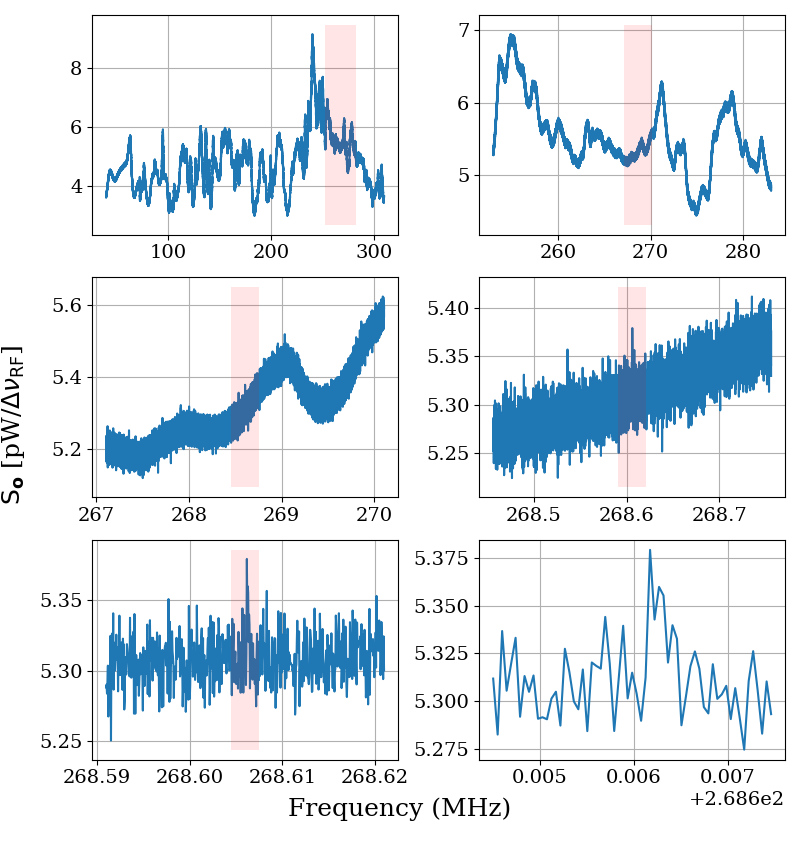

In [197]:
#the following 3 cells must run in order after the previous cell. The last one (matched filtering) will break following cells, so you should run the 
#previous cell again after that one.

###TO GO TO 2x2!!! 
#change the zoom_levels, plt.subplot to 2,2 AND the if i<5 to i<3

# Function to find index range for given frequency range
def freq2IdxRange(start_freq, stop_freq, freqs):
    start_idx = freq2Idx(start_freq, freqs)
    stop_idx = freq2Idx(stop_freq, freqs)
    return start_idx, stop_idx

#analysis params
medFiltBins = 51
butterFreq  = 40000
butterOrder = 6

requiredSigma = get_required_sigma(2**23*(250/400), 0.95)
print(requiredSigma)
# Fit H to spec
medianFilt = median_filt(specArr[:, 1], filter_size=medFiltBins)
H = (butter_filt(medianFilt, cutoff = butterFreq, order = butterOrder))

#Norm spec: mean = 1, STD = 1
normSpec    = (specArr[:, 1] / H)
startIdx, stopIdx = freq2IdxRange(50e6, 300e6, freqs)
normSpecStd = np.std(normSpec[startIdx:stopIdx])

# Define the zoom levels (in MHz)
zoom_levels = [(40, 310), (258, 278), (268, 269), (268.597, 268.615)]
zoom_levels = [(40, 310),(253, 283),(267.106, 270.106),(268.456, 268.756),(268.591, 268.621),(268.6045, 268.6075)]

# Close all existing plots
plt.close('all')



# Create a 2x2 subplot
fig, axs = plt.subplots(3, 2, figsize=(8, 8.5))  # Adjust figsize to fill a full page

for i, (start_freq, stop_freq) in enumerate(zoom_levels):
    row = i // 2
    col = i % 2
    start_idx, stop_idx = freq2IdxRange(start_freq * 1e6, stop_freq * 1e6, freqs)
    axs[row, col].plot(freqs[start_idx:stop_idx]/1e6, specArr[start_idx:stop_idx, 1]/1e-12, label=f'{40} averages')
    #axs[row, col].plot(freqs[start_idx:stop_idx]/1e6, (H*(normSpecStd*requiredSigma+1))[start_idx:stop_idx]/1e-12, color='r', linestyle='--', linewidth=1)

    axs[row, col].grid(True)
    # Limit the number of x-ticks to 4
    if i > 5:
        axs[row, col].xaxis.set_major_locator(plt.MaxNLocator(4))
    
    # Add a filled region for the zoom area in the next subplot for the first three subplots
    if i < 5:
        next_start_freq, next_stop_freq = zoom_levels[i+1]
        axs[row, col].fill_betweenx(axs[row, col].get_ylim(), next_start_freq, next_stop_freq, color='red', alpha=0.1, edgecolor = 'none', zorder = 100)


# Add a single x-axis label
fig.text(0.5, 0.04, 'Frequency (MHz)', ha='center', fontsize=18)
fig.text(-.0, 0.5, r'$\mathrm{S}_\mathbf{o}$ [pW/$\Delta \nu_\mathrm{RF}$]', va='center', fontsize = 18, rotation = 90)

    
plt.tight_layout(rect=[0.03, 0.03, 1, 1])
plt.show()


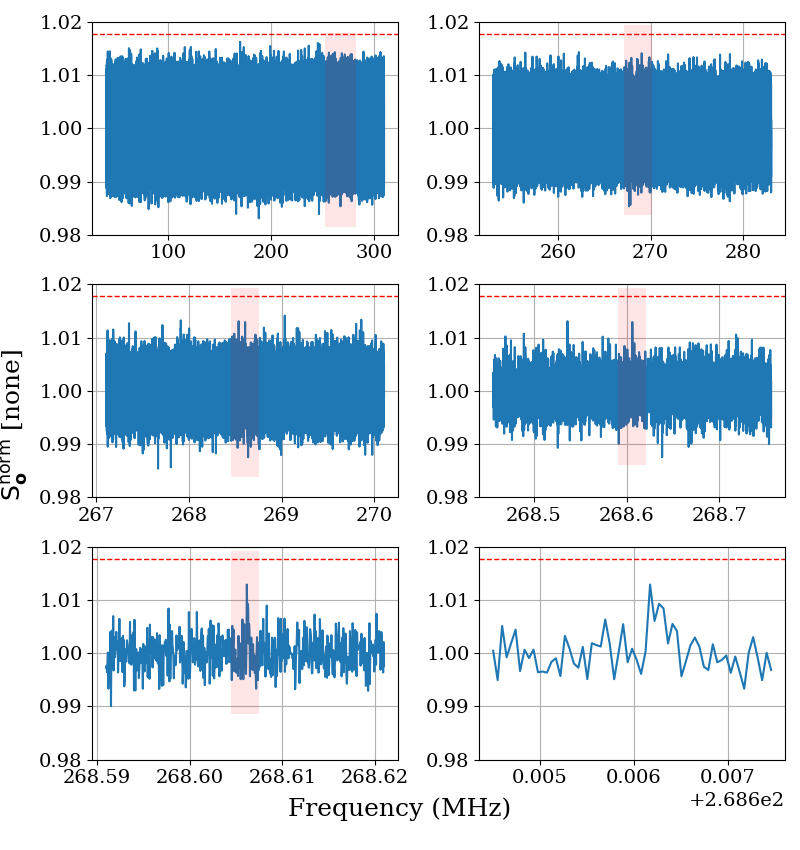

In [198]:


# Define the zoom levels (in MHz)
zoom_levels = [(40, 310), (258, 278), (268, 269), (268.597, 268.615)]
zoom_levels = [(40, 310),(253, 283),(267.106, 270.106),(268.456, 268.756),(268.591, 268.621),(268.6045, 268.6075)]

# Close all existing plots
plt.close('all')


# Create a 2x2 subplot
fig, axs = plt.subplots(3, 2, figsize=(8, 8.5))  # Adjust figsize to fill a full page

for i, (start_freq, stop_freq) in enumerate(zoom_levels):
    row = i // 2
    col = i % 2
    start_idx, stop_idx = freq2IdxRange(start_freq * 1e6, stop_freq * 1e6, freqs)
    axs[row, col].plot(freqs[start_idx:stop_idx]/1e6, normSpec[start_idx:stop_idx], label=f'{40} averages')
    axs[row, col].axhline(y=normSpecStd*requiredSigma+1, color='r', linestyle='--', linewidth=1)
    
    axs[row, col].grid(True)

    # Add a filled region for the zoom area in the next subplot for the first three subplots
    if i < 5:
        next_start_freq, next_stop_freq = zoom_levels[i+1]
        axs[row, col].fill_betweenx(axs[row, col].get_ylim(), next_start_freq, next_stop_freq, color='red', alpha=0.1, edgecolor = 'none', zorder=100)
    axs[row, col].grid(True)
    axs[row, col].set_ylim(.98,1.02)
    # Limit the number of x-ticks to 4
    if i > 5:
        axs[row, col].xaxis.set_major_locator(plt.MaxNLocator(4))

# Add a single x-axis label
fig.text(0.5, 0.04, 'Frequency (MHz)', ha='center', fontsize=18)
fig.text(-.0, 0.5, r'$\mathrm{S}_\mathbf{o}^\mathrm{norm}$ [none]', va='center', fontsize = 18, rotation = 90)

    
plt.tight_layout(rect=[0.03, 0.03, 1, 1])
plt.show()


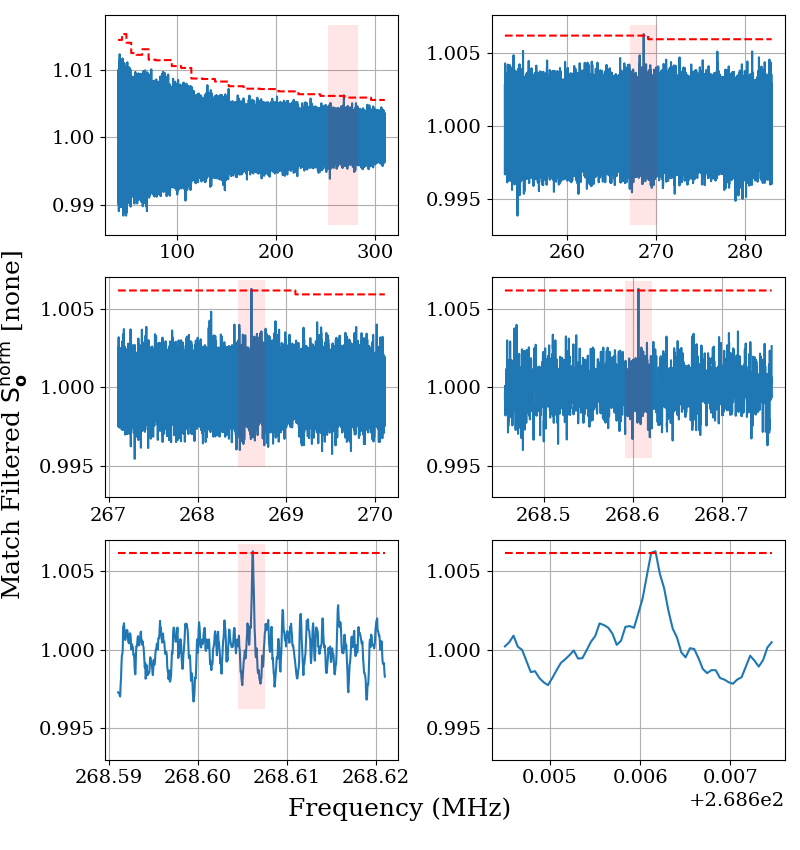

In [201]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
freqs = np.linspace(0, 400, 2**23, dtype=np.float64)  # MHz
startFreq = 40  # MHz
stopFreq = 310  # MHz
percent = 10  # matched filter
overlap = 100  # matched filter, bins
CL = 0.95  # confidence limit

# Matched filter output
matchedOut = matched_filt(freqs=freqs, spec=normSpec, startFreq=startFreq, stopFreq=stopFreq, percent=percent, overlap=overlap)
matchedFreqs = matchedOut[0]
matchedSpec = matchedOut[1]

# Set limits and get the necessary values
nSigmaTup = set_lim(matchedFreqs, matchedSpec, CL)
matchedFreqs = nSigmaTup[0]
matchedSpec = nSigmaTup[1]
matchedLim = nSigmaTup[2]

# Define the zoom levels (in MHz)
zoom_levels = [(40, 310), (258, 278), (268, 269), (268.597, 268.615)]
zoom_levels = [(40, 310),(253, 283),(267.106, 270.106),(268.456, 268.756),(268.591, 268.621),(268.6045, 268.6075)]

# Close all existing plots
plt.close('all')

# Function to find index range for given frequency range
def freq2IdxRange(start_freq, stop_freq, freqs):
    start_idx = np.searchsorted(freqs, start_freq)
    stop_idx = np.searchsorted(freqs, stop_freq)
    return start_idx, stop_idx

# Create a 2x2 subplot
fig, axs = plt.subplots(3, 2, figsize=(8, 8.5))  # Adjust figsize to fill a full page

for i, (start_freq, stop_freq) in enumerate(zoom_levels):
    row = i // 2
    col = i % 2
    start_idx, stop_idx = freq2IdxRange(start_freq, stop_freq, matchedFreqs)
    axs[row, col].plot(matchedFreqs[start_idx:stop_idx], matchedSpec[start_idx:stop_idx], label=f'{40} averages')
    axs[row, col].plot(matchedFreqs[start_idx:stop_idx], 1+matchedLim[start_idx:stop_idx], color = 'r', linestyle = '--')
    axs[row, col].grid(True)
    
    # Add a filled region for the zoom area in the next subplot for the first three subplots
    if i < 5:
        next_start_freq, next_stop_freq = zoom_levels[i+1]
        axs[row, col].fill_betweenx(axs[row, col].get_ylim(), next_start_freq, next_stop_freq, color='red', alpha=0.1, edgecolor='none', zorder = 100)
        # Add a filled region for the zoom area in the next subplot for the first three subplots
    if i > 1:
        axs[row, col].set_ylim(.993, 1.007)

# Add a single x-axis label
fig.text(0.5, 0.04, 'Frequency (MHz)', ha='center', fontsize=18)
fig.text(-.0, 0.5, r'Match Filtered $\mathrm{S}_\mathbf{o}^\mathrm{norm}$ [none]', va='center', fontsize = 18, rotation = 90)

plt.tight_layout(rect=[0.03, 0.03, 1, 1])
plt.show()


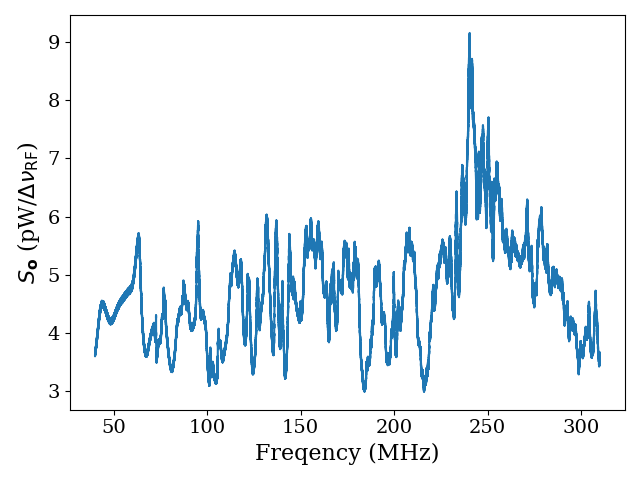

In [22]:
#plot raw spectra

plt.close('all')
pltIdxStart     = freq2Idx(40e6, freqs)
pltIdxStop     = freq2Idx(310e6, freqs)
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, ((specArr[:, 1]))[1:][pltIdxStart:pltIdxStop]/1e-12, label = f'{40} averages')
plt.ylabel(r'$S_\mathbf{o}$ (pW/$\Delta \nu_\mathrm{RF}$)')
plt.xlabel('Freqency (MHz)')
plt.tight_layout()

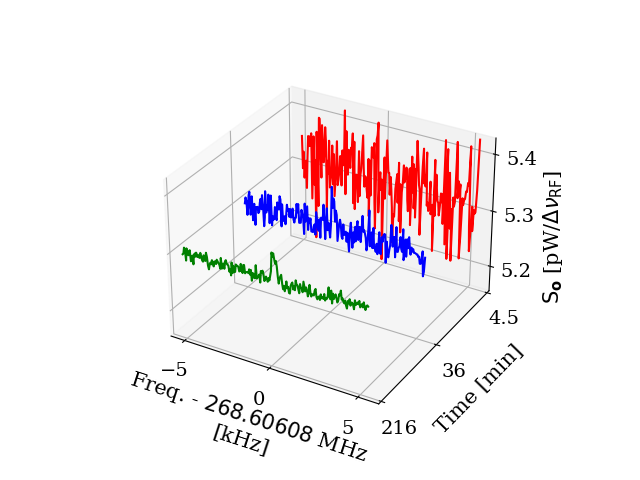

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.close('all')
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=14, labelsize=15)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=18)

pltIdxStart     = freq2Idx(268.5955e6, freqs)
pltIdxStop     = freq2Idx(268.615e6, freqs)

#+-5kHz span
pltIdxStart     = freq2Idx(268.601e6, freqs)
pltIdxStop     = freq2Idx(268.6115e6, freqs)

#+-2.5kHz span
#pltIdxStart     = freq2Idx(268.6038e6, freqs)
#pltIdxStop     = freq2Idx(268.6089e6, freqs)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'blue', 'green']  # Add as many colors as needed

for i, numAvg in enumerate(numAvgList):
    ax.plot((freqs[pltIdxStart:pltIdxStop] - 268606084) / 1e3,
            (specArr[:, i])[pltIdxStart:pltIdxStop] / 1e-12,
            zs=i, zdir='y', color=colors[i % len(colors)])
labelpad =8
#ax.set_xlabel(r'Frequency - $\nu_\mathrm{injection}$'+'\n[kHz]', labelpad= labelpad+1)
ax.set_xlabel(r'Freq. - $268.60608$'+' MHz\n[kHz]', labelpad= labelpad+1)
ax.set_ylabel('Time [min]', labelpad=labelpad)
#ax.set_zlabel(r'$\mathrm{S}_\mathbf{o}$' +'' + r' [pW/$\Delta \nu_{\mathrm{RF}}$]', labelpad=labelpad)

#Adjust the z-label position manually using a text object
#ax.set_zlabel(r'$\mathrm{S}_\mathbf{o}$' + r' [pW/$\Delta \nu_{\mathrm{RF}}$]')
ax.text2D(1.075, .35, r'$\mathrm{S}_\mathbf{o}$' + r' [pW/$\Delta \nu_{\mathrm{RF}}$]', transform=ax.transAxes, rotation=90, fontsize = 15)




#ax.invert_yaxis()
#ax.set_xlim(268, 269)
#ax.set_ylim(np.sqrt(max(numAvgList)*4.5), np.sqrt(min(numAvgList)*4.5))
#ax.set_ylim((max(numAvgList)*4.5), np.sqrt(min(numAvgList)*4.5))
ax.set_ylim(2, 0)
#ax.set_zlim(-84, -79)

# Custom ticks for Y-axis
custom_ticks = [0, 1, 2]  # Positions of the ticks
custom_labels = ['4.5', '36', '216']  # Custom labels for the ticks

ax.set_yticks(custom_ticks)
ax.set_yticklabels(custom_labels)

# Custom ticks for z-axis (power)
custom_ticks = [5.2, 5.3, 5.4]  # Positions of the ticks
ax.set_zticks(custom_ticks)

# Custom ticks for x-axis (frequency)
#custom_ticks = [-10, 0, 10]  # Positions of the ticks
custom_ticks = [-5, 0, 5]  # Positions of the ticks
#custom_ticks = [-2.5, 0, 2.5]  # Positions of the ticks
ax.set_xticks(custom_ticks)
#ax.set_xlim(-3,3)

plt.savefig('plot.png', bbox_inches='tight', dpi = 300)
plt.show() 

In [ ]:
#Show noise goes like sqrt time

#location of packed h5
fileName        = 'packedh5.hdf5'
freqs       = np.linspace(0, 400e6, 2**23, dtype=np.float64)


def generate_acq_nums(dataframe, numAvg):
#given numAvg, returns a list of acqNums for the first numAvg of each new antPosIdx
    result = []
    grouped = dataframe.groupby('ANT POS IDX')
    for name, group in grouped:
        result.extend(group['ACQ NUM'].tail(numAvg).tolist())
    return result



def avgSpecFromPacked(avgIdxs, specStr):
    sum = np.zeros(2**23+1)
    for i in avgIdxs:
        sum += f[specStr][:,i]
    avgSpec = sum/(len(avgIdxs))
    return avgSpec

f               = h5py.File(dataDir + fileName, 'r')

numAvgList = np.arange(1,48,8)

freqs       = np.linspace(0, 400, 2**23, dtype=np.float64) #MHz!
specArr = np.zeros((len(freqs)+1, len(numAvgList)))
medFiltBins = 51
butterFreq  = 40000
butterOrder = 6
startFreq   = 50   # MHz
stopFreq    = 60   # MHz
idxStart    = freq2idx(startFreq, freqs)
idxStop     = freq2idx(stopFreq, freqs)

plt.close('all')
plt.figure()
stdList = []
madList = []
for i, numAvg in enumerate(numAvgList):
    antIdx              = generate_acq_nums(databaseDf, numAvg)
    print(antIdx)
    avgAntSpec          = avgSpecFromPacked(antIdx, 'spec_W_chB')[idxStart:idxStop]
    medianFilt = median_filt(avgAntSpec, filter_size=medFiltBins)
    H = (butter_filt(medianFilt, cutoff = butterFreq, order = butterOrder))

    #Norm spec: mean = 1, STD = 1
    normSpec    = avgAntSpec / H 
    print(np.std(normSpec))
    #plt.plot(freqs[idxStart:idxStop], normSpec)
    madList.append(scipy.stats.median_abs_deviation(normSpec)*1.4826)
    stdList.append(np.std(normSpec))
f.close()




In [ ]:
plt.close('all')
plt.figure()
plt.scatter(numAvgList*4.5, (np.asarray(stdList)), label = '1.4826*MAD of norm spec', color = 'r' )
plt.plot(numAvgList*4.5, (1/np.sqrt(47.7*4.5*60*numAvgList)), label = r'$(\Delta \nu_\mathrm{RF} \mathrm{time})^{-1/2}$')
plt.xlabel('Time [min]')
plt.ylabel('STD of norm. spec. [none]')
plt.legend()
plt.tight_layout() 

 

 

In [ ]:
# Calculate predicted values
predicted = 1 / np.sqrt(47.7 * 4.5 * 60 * numAvgList)

# Calculate residuals
residuals = stdList - predicted


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Original plot
ax1.scatter(numAvgList * 4.5, stdList, label='STD of norm spec', color='r')
ax1.plot(numAvgList * 4.5, predicted, label=r'$(\Delta \nu_\mathrm{RF} \mathrm{time})^{-1/2}$')
ax1.set_ylabel('STD of norm. spec. [none]')
ax1.legend()
ax1.grid(True)


# Plotting residuals
ax2.scatter(numAvgList * 4.5, residuals, label='Residuals', color='b')
ax2.axhline(0, color='gray', linestyle='--')
ax2.set_xlabel('Time [min]')
ax2.set_ylabel('Residuals [none]')
ax2.legend()
ax2.grid(True)


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
